In [16]:

import re
import os
import sys
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx
import pybedtools as bt
from scipy import stats

from scipy.spatial import distance
from scipy.cluster import hierarchy

from scipy.stats import spearmanr
from adjustText import adjust_text



import matplotlib.patches as mpatches
import matplotlib.collections as mcol

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib_venn import venn2

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]
color3=mcp.gen_color(cmap="Oranges",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
sns.set(style="ticks", font_scale=2)

mcp.gen_color(cmap="Purples",n=10)[-7:-2]

def flatten(l):
    return [item for sublist in l for item in sublist]




BEDPRO = pickle.load(open('data/P/BEDPRO.p', 'rb'))

# N contains BW signal for RNA seq but BEDPRO contains  
N = pd.read_table('data/TABLE/Epigenome.tmm.tsv').set_index('Name').drop_duplicates()

MAPty = pickle.load(open('data/MAP/MAPty.p', 'rb'))
MAPcl = pickle.load(open('data/MAP/MAPcl.p', 'rb'))
MAPgn = pickle.load(open('data/MAP/MAPgn.p', 'rb'))

H = pickle.load(open('data/G/G_ALL.p', 'rb'))



np.random.seed(7)
andr = [n for n, nc in MAPcl.items() if nc == 'ANDR']
high = np.random.choice([n for n, nc in MAPcl.items() if nc == 'High'], size=len(andr))
midh = np.random.choice([n for n, nc in MAPcl.items() if nc == 'Mid-high'], size=len(andr))
len(high), len(midh), len(andr)

(89, 89, 89)

In [17]:
!intervene venn -i data/ALL/ATAC.ALL.bed data/ALL/FOXA1.ALL.bed -o data/VENN/FOXA1vsATAC --save-overlaps

bed = pd.read_table('data/VENN/FOXA1vsATAC/sets/11_ATAC.ALL_FOXA1.ALL.bed', names=['Chr', 'Start', 'End'])
bed['Name'] = bed['Chr'] +':'+ bed['Start'].astype(str) +'-'+ bed['End'].astype(str)
bed['Set'] = bed['Name'].map(MAPcl)

foxar = bed.loc[bed['Set'] == 'ARcre', 'Name'].tolist()
foxcre = bed.loc[bed['Set'] == 'cre', 'Name'].tolist()

l = list(set(flatten([list(H.neighbors(a)) for a in andr if a in H.nodes])))
arcre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'ARcre') & (l_ in foxar) ]
print( len(arcre_andr_kac_fox))

cre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'cre') & (l_ in foxcre) ]
print( len(cre_andr_kac_fox))

l = list(set(flatten([list(H.neighbors(a)) for a in andr  if a in H.nodes])))
cre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

l = list(set(flatten([list(H.neighbors(a)) for a in high  if a in H.nodes])))
cre_high_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

l = list(set(flatten([list(H.neighbors(a)) for a in high  if a in H.nodes])))
arcre_high_kac = [l_ for l_ in l if MAPcl[l_] == 'ARcre']


Generating a 2-way "venn" diagram. Please wait...


Done! Please check your results @ data/VENN/FOXA1vsATAC. 
Thank you for using Intervene!

192
228


### Promoters

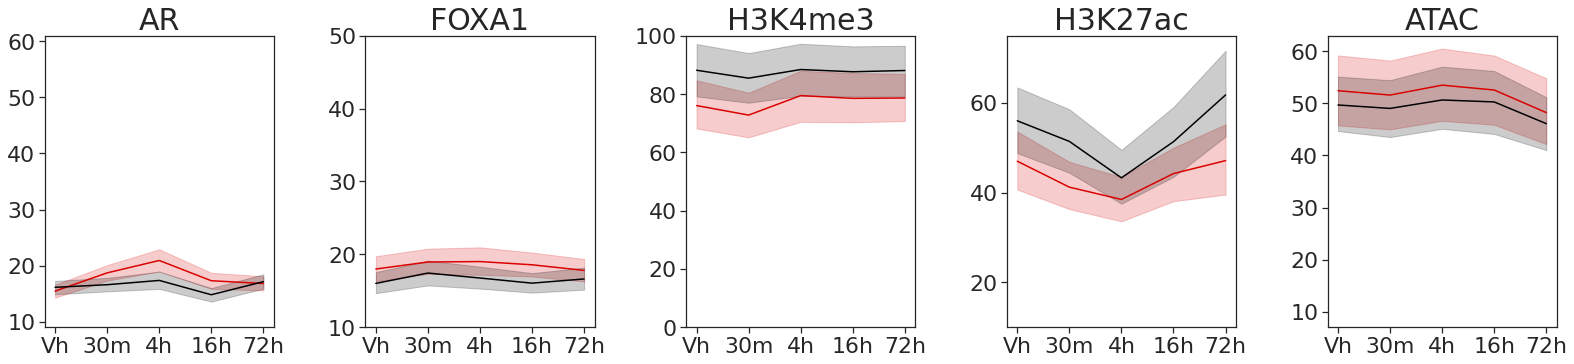

In [18]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

ylims = {'AR': (9,61), 'FOXA1': (10,50), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,63)}

for i, s in enumerate(['AR', 'FOXA1', 'H3K4me3', 'H3K27ac', 'ATAC']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(andr)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#DA0000')


    n = N[N.index.isin(high)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#000000')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)
    plt.ylim(ylims[s])
    
    
#fig.supylabel('TMM Normalized',fontsize=30)

fig.savefig('plots/Epigenome_Promoters.pdf', bbox_inches ="tight",  pad_inches = 1 )

### Enhancers

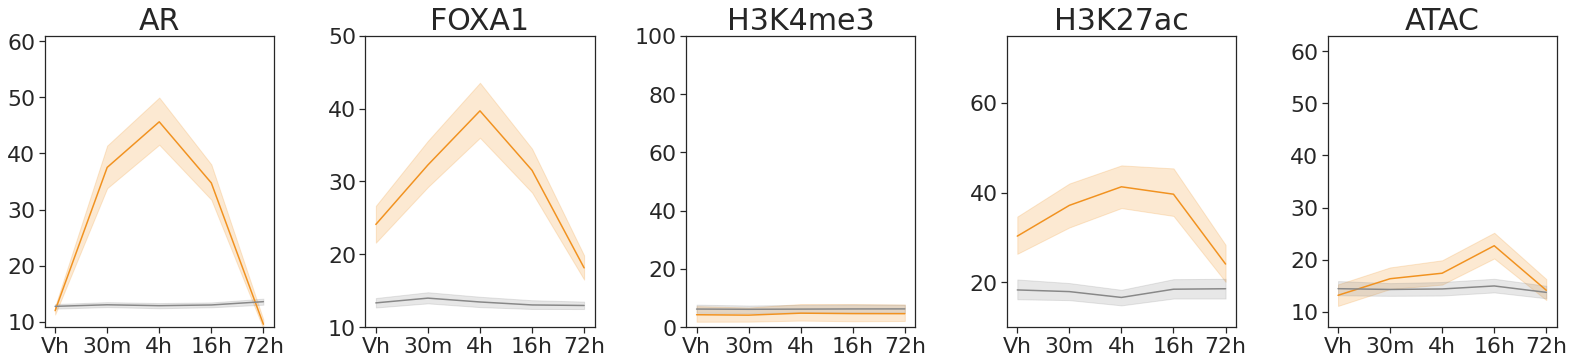

In [19]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

ylims = {'AR': (9,61), 'FOXA1': (10,50), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,63)}

for i, s in enumerate(['AR', 'FOXA1', 'H3K4me3', 'H3K27ac', 'ATAC']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#F19220')


    n = N[N.index.isin(cre_high_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#888888')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)
    plt.ylim(ylims[s])

    
#fig.supylabel('TMM Normalized',fontsize=30)

fig.savefig('plots/Epigenome_Enhancers.pdf', bbox_inches ="tight",  pad_inches = 1 )

### FOXA1 

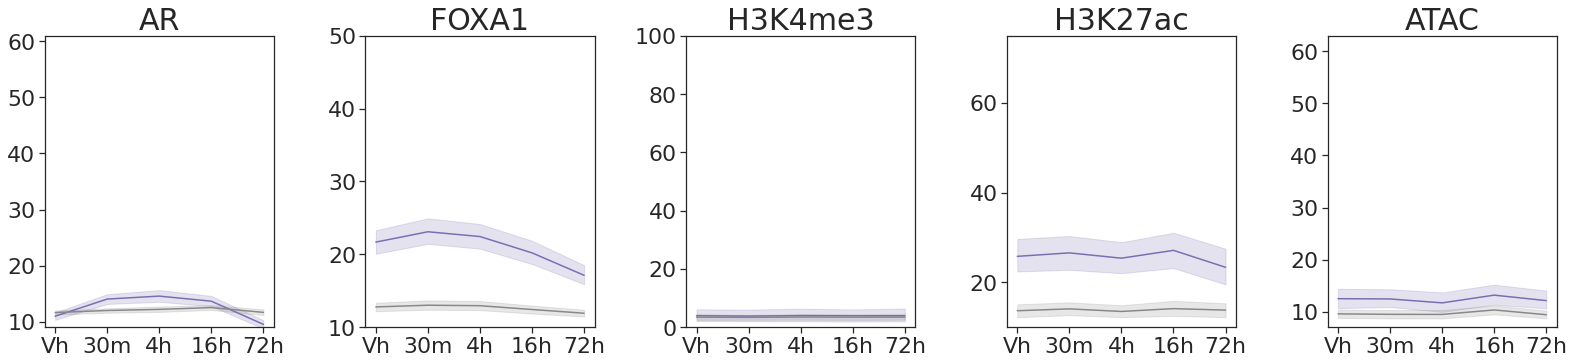

In [20]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

ylims = {'AR': (9,61), 'FOXA1': (10,50), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,63)}

for i, s in enumerate(['AR', 'FOXA1', 'H3K4me3', 'H3K27ac', 'ATAC']):
    fig.add_subplot(gs[i])

    n = N[N.index.isin(cre_andr_kac_fox)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#7A6EB2')


    n = N[N.index.isin(cre_andr_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#888888')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])

    
    
#fig.supylabel('TMM Normalized',fontsize=30)

fig.savefig('plots/FOXA1_Epigenome.pdf', bbox_inches ="tight",  pad_inches = 1 )


### Down regulated genes

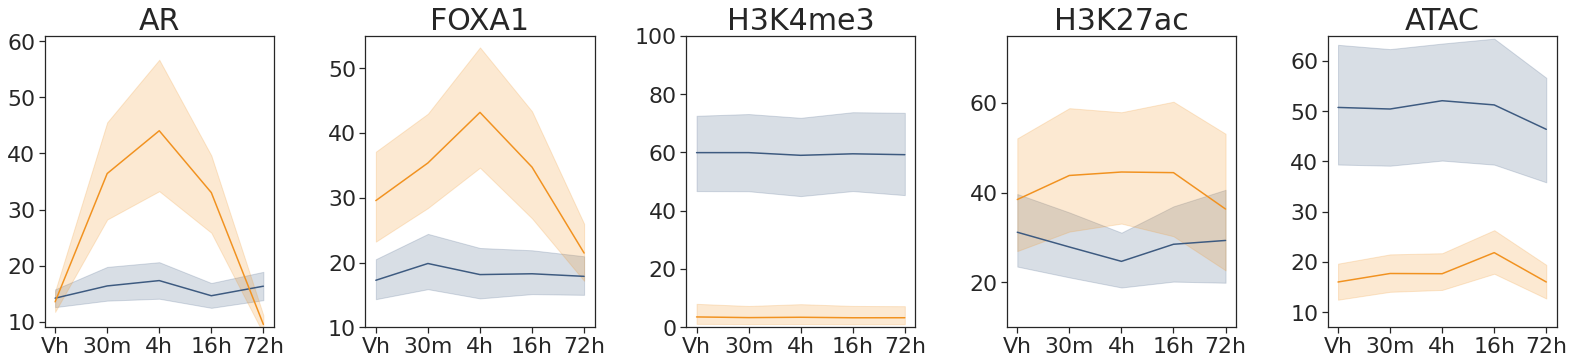

In [21]:
down = pickle.load(open('data/P/downgenes.p', 'rb'))

l = list(set(flatten([list(H.neighbors(a)) for a in down if a in H.nodes])))
arcre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'ARcre') & (l_ in foxar) ]


fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

ylims = {'AR': (9,61), 'FOXA1': (10,55), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,65)}

for i, s in enumerate(['AR', 'FOXA1', 'H3K4me3', 'H3K27ac', 'ATAC']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(down)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#3d5a80')


    n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#F19220')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])


#fig.supylabel('TMM Normalized',fontsize=30)

    
fig.savefig('plots/Down_Epigenome.pdf', bbox_inches ="tight",  pad_inches = 1 )